# 1D Ising Model

This notebook will guide you through some aspects of the one-dimensional Ising model. The Ising Model originated from magnetism, but has many other applications as well. It models the interactions between neighbooring sites as


$$
H(\{\sigma\}) = \sum_{i,j} J \cdot \sigma_i\sigma_j - \mu \sigma_i \quad \sigma_i\in\{-1,+1\}
$$

Each site can be in one of two states (e.g., spin up $\uparrow$ and spin down $\downarrow$). If the exchange energy $J$ is positive, anti-aligned spin pairs ($\uparrow\downarrow$) are favoured, otherwise aligned spin pairs ($\uparrow\uparrow$) are energetically advantageous. The point term represents interactions with an external field $\mu$. The spin variables $\sigma_i$ can take on two values: $+1$ and $-1$, respectively. These choices to designate the spin states are not unique, but they make some of the math simpler.

## Helping functions

Before turning to solution schemes for the Ising model, we load needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

and define some helpful functions.

### Lattice state iterator

For some of the solution approaches, we need to iterate over all possible states of the lattice. This is best done with an iterator. Itertors are a handy feature of python that allow to generate sequences of values that are returned by `yield` each time the iterator is accessed.

This iterator returns an array containing spin variables $[\pm 1,\pm 1,\dots,\pm 1]$. 

> The implementation utilised the bit representation of integers, e.g., 3 -> 00000010, which allows to iterate through all possible states by simply incrementing a number.  

In [2]:
## Create a 1D lattice of spin variables
def lattice_iterator(N):
    '''
    Create an iterator that iterates over all possible states {-1,+1} of a set of spin variables
    
    This simple implementation expoits binary representations of intergers with some padding
    '''
    
    n=-1
    M=2**N
    d = np.zeros(N) - 1;
    
    while n<(M-1):
        n=n+1
        bit = [1 if digit == '1' else -1 for digit in bin(n)[2:]]
        d[N-len(bit):] = bit
        yield d, n
        
for n,i in enumerate(lattice_iterator(1)):
    print(n, 'i = ', i)

0 i =  (array([-1.]), 0)
1 i =  (array([1.]), 1)


## Operators

The matrix transform formalism explained below utilises **operators** acting on a function space. In computational studies, these operators take the form of matrices (similar to the formalism that you have already seen in the FEM method). Generally, an operator matrix contains the value of the operator for two states that are combined with each other through the operator in each of its matrix cells.

### Magnetisation

The Magnetisation operator only depends the state at hand. Drawing another analogy to the FEM formalism, it is similar to a linear form (while the Hamiltonian that we look at next is similar to a bilinear form). The matrix is of size $2^M\times 2^M$, because this is the numer of possible states for a chain of length $M$. The magnetisation operator holds the total spin on its main diagonal for each possible spin configuration, which is constructed using the `lattice_iterator` that has been defined earlier. 

In [3]:
def magnetisation(M):
    m=np.zeros((2**M,2**M))
    for s,i in lattice_iterator(M):
        m[i,i] = np.sum(s)
    return np.matrix(m)

print(magnetisation(2))

[[-2.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  2.]]


### Hamiltonian

The Hamiltonian is a sum over point and pair terms. The `point` function sums all spin values over an array of spins. The `pair` function sums products of spin variables $\sigma_a\sigma_b$ over pairs of neighbouring lattices. The benefit of this approach will become apparent later. It can be thought of as "summing over the rugs of a ladder".

The `hamiltonian` itself computes the energy of all possible arrangements of two spin chains, and returns the resulting energies as a matrix. For, example the Hamiltonian matrix with just one spin per chain looks like this:

$$
\begin{array}{r|cc}
           & \uparrow             & \downarrow\\
  \hline
  \uparrow & J(+1)(+1) - \mu(+1) & J(+1)(-1) - \mu(-1)\\
  \downarrow & J(+1)(-1) - \mu(+1) & J(-1)(-1) - \mu(-1)\\
\end{array}
\quad\rightarrow\quad{\bf H}_1 = \left[
\begin{array}{cc}
J-\mu & -J+\mu \\
-J-\mu & J+\mu\\
\end{array}
\right]
$$

In this representation, spin states are described by a state vector $|\sigma\rangle$ (using Dirac notation, which we will learn more about later). For now, you can think of it as a fancy way of writing a vector:

$$
\begin{array}{rcl}
|\uparrow\rangle & = & [1,0]\\
|\downarrow\rangle & = & [0,1]\\
\end{array}
$$

The elements of the Hamiltonian, are then given by $H_{ij} = \langle\sigma_i|H|\sigma_j\rangle$.

In [4]:
def point(lat,na):
    '''
    Sum the spins over the lattice
    '''
    res = 0
    for i in range(na):
        res += lat[i]

    return res

## Define functions for summing over lattice states for 
## intra-layer and trans-layer interactions
def pair(lat_a,lat_b,n):
    '''
    Sum intra-layer interactions over a lattice state
    '''
    res = 0
    for i in range(n):
        res += lat_a[i]*lat_b[i]
    return res

def hamiltonian(J,mu,M):
    H=np.zeros((2**M,2**M))
    for s,i in lattice_iterator(M):
        for t,j in lattice_iterator(M):
            H[i,j] = J*pair(s,t,M) - mu*point(s,M)
    return H

## Solutions

### Brute force

The aim is to compute the thermoodynamic properties of the spin chain, namely the free energy and average spin as a function of temperature and the model parameters. Statistical Mechanics provides the tools to establish this link.

The central quantity in Statistical Mechanics is the **Partition Function**:

$$
Z = \sum_{\{\sigma\}}\exp(-\beta\cdot H(\{\sigma\}))
$$

The partition function sums over *all possible* states $\{\sigma\}$ of the spin chain, weighting each state by the exponential of the states energy $H(\{\sigma\})$ divided by $kT$. It is common to use $\beta = 1/kT$ to save some writing. This quickly becomes computationally *very* expensive. The 1D spin-chain with $N$ sites has $2^N$ possible configurations. To make this explicit, a chain with 4 sites has 16 states. A chain with 10 sites has 1024 sites, and a chain with 20 sites has 1,048,576 states.

The free energy $g$ is directly computed from the partition function using the thermodynamic identity

$$
g = -kT\cdot\ln(Z)/N
$$

The internal energy and magnitisation is computed using explicit summation:

$$
u = \langle H\rangle = \sum_{\{\sigma\}}H_i\cdot\exp\{-\beta\cdot H_i\}\\
m = \langle \sigma\rangle = \sum_{\{\sigma\}}\left(\sum\sigma\right)\cdot\exp\{-\beta\cdot H_i\}
$$

where $\left(\sum\sigma\right)$ is the sum of spins for a given configuration.

In [5]:
def brute_force(M,J,mu,kTs):
    '''
    Solve the one-dimensional Ising model by explicitly summing over all states to compute
    partition function, free energy, internal energy, and magnetisation.
    
    The function returns the results as a Pandas dataframe.
    
    Parameters:
        
        M   - length of spin chain
        J   - exchange interaction
        mu  - external field (same units as J)
        kTs - array with temperatures (in units of J)
    
    Returns:
    
        A Pandas dataframe with free energy g, internal energy u, magnetisation m
        
    Usage: 
        
        brute_force(10,-1,0.1,np.linspace(0.1,4,30))
    '''
    
    # Create a new data-frame to take results
    df = pd.DataFrame(columns=['kT','g','u','m','mu','J'],dtype=object)
    
    # Iterate over temperatures
    for i,kT in enumerate(kTs):
        beta =1/kT
        Z = m = g = u = 0
        
        # Iterate over all possible spin states
        # of a spin chain with length M
        for l,j in lattice_iterator(M):
            H = J*pair(l,np.roll(l,1),M)-mu*point(l,M)
            Z += np.exp(-beta*H)
            m += np.sum(l)*np.exp(-beta*H)
            u += H*np.exp(-beta*H)

        # Normalise sums and compute free energy
        m = m/Z/M
        u = u/Z/M
        g = -1/beta*np.log(Z)/M
        
        # Append result to dataframe
        s = pd.DataFrame({'g': [g], 'u': [u], 'kT': [kT], 'm': [m], 'mu': [mu], 'J': [J], 'M':[M]})
        df = pd.concat([df,s])
 
    return df

#brute_force(10,-1,0.1,np.linspace(0.1,4,30))

### Execise 1: AFM solution of the 1D Ising model

Let's investigate a simple 1D Ising chain with direct summation of the partition function. We will look at the anti-ferro-magnetic solution by setting $J<0$ and vary the 

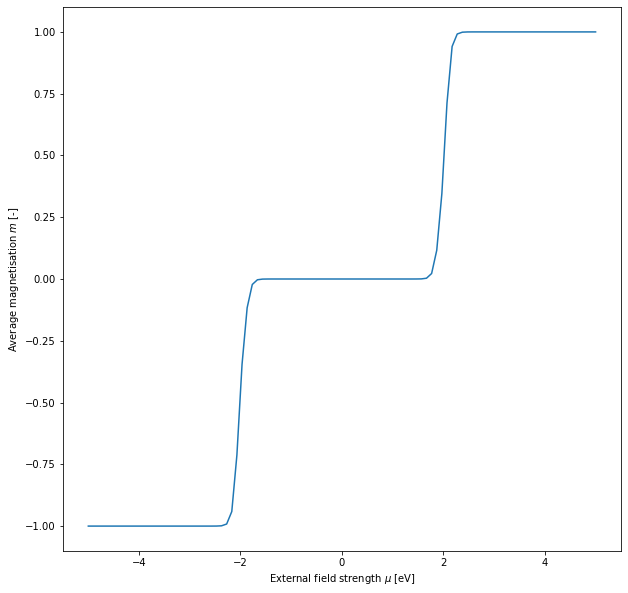

In [6]:
# Parameters
M = 10      # Size of the spin chain 
J = 1      # Exchange interaction
kT = 0.1   # Temperature

# Prepare plots
df = pd.DataFrame()

# Brute-Force (green)
for mu in np.linspace(-5,5,100):
    bf = brute_force(M,J,mu,[kT])
    df = pd.concat([df,bf])

plt.figure(figsize=(10,10));
plt.plot(df.mu,df.m);
plt.xlabel('External field strength $\mu$ [eV]');
plt.ylabel('Average magnetisation $m$ [-]');
plt.show()

### Transfer Matrix

The Transfer Matrix approach exploits a *duality* between the 1D Ising Model and a 0D quantum mechanical problem. The problem is recast into an eigenvalue problem of a $2\times 2$ matrix, which is very efficient to solve (even analytically as we will see below). 

Lets start with the usual partition function

$$
Z= \sum_{\{\sigma\}} \exp(-\beta H_i) = \sum_{\{\sigma\}} \exp\left(-\beta \sum_j(J\sigma_j\sigma_{j+1} +\mu\sigma_j) \right)=\sum_{\{\sigma\}}\prod_j\exp(-\beta(\underbrace{J\sigma_j\sigma_{j+1} +\mu\sigma_j}_{=H_{j,j+1}}))
$$

Now we switch to the matrix representation that is described earlier by letting

$$
T_{j,j+1} = \exp(-\beta\cdot H_{j,j+1}) = \rightarrow \langle j|T| j+1\rangle = \langle j|\exp(-\beta H)| j+1\rangle
$$

With this definition, the partition function becomes

$$
Z = \sum_{\{\sigma\}}\langle 1|T| 2\rangle\langle 2|T| 3\rangle\dots\langle N|T|1\rangle
$$

where the last term exploits periodic boundary conditions. Now we recall that $|i\rangle$ really only is a vector and $\langle i|$ is its (conjugate) transpose. So $|i\rangle\langle i|$ is the *outer* product (or tensor product) of a unit vector. In quantum mechanics, it is called the projection operator. An important property of the projection operator is that 

$$
I = \sum_n |n\rangle\langle n|
$$

the sum over all projections is the identity. This can be understood as taking a vector and projecting out all its components and then summing up the components, which restores the vector. 

Because the sum of the partition function is over all spin configurations, it contains sums over all projection operators apart from $|1\rangle\langle 1|$. This greatly simplifies the sum over products, as can be demonstrated with a simple two site chain:

$$
\begin{array}{rcll}
Z & = & \langle1_+|T|2_+\rangle\langle2_+|T|1_+\rangle & (+,+)\\
  & + & \langle1_+|T|2_-\rangle\langle2_-|T|1_+\rangle & (+,-)\\
  & + & \langle1_-|T|2_+\rangle\langle2_+|T|1_-\rangle & (-,+)\\
  & + & \langle1_-|T|2_-\rangle\langle2_-|T|1_-\rangle & (-,-)\\
  & = & \langle1_+|T|\left[\underbrace{|2_+\rangle\langle2_+|+|2_-\rangle\langle2_-|}_{=I}\right]|T|1_+\rangle\\
  & + & \langle1_-|T|\left[\underbrace{|2_+\rangle\langle2_+|+|2_-\rangle\langle2_-|}_{=I}\right]|T|1_-\rangle\\
  & = & \langle1_+|T^2|1_+\rangle + \langle1_-|T^2|1_-\rangle\\
\end{array}
$$

In general you have

$$
\begin{array}{rcl}\displaystyle
Z & = & \sum_{\{\sigma\}}\langle 1|T| 2\rangle\langle 2|T| 3\rangle\dots\langle N|T|1\rangle\\
  & = & \sum_{\sigma = \pm 1}\langle1|T^N|1\rangle\\
  & = & {\rm Tr}({\bf T^N})
\end{array}
$$

The partition function can, therefore, be computed from the trace of the N-th power of the transfer matrix through this interesting duality with quantum mechanics.

Taking the $N$-th power of a matrix, however, is still an expensive operation if $N$ is large. This can be avoided by rotating the basis states so that ${\bf T}$ becomes diagonal. In this basis, the eigenvalues $\lambda_i$ of ${\bf T}$ occupy the main diagonal and the trace becomes:

$$
{\rm Tr}({\bf T}^N) = \sum \lambda_i^N
$$

In [7]:
def transfer_matrix(M,J,mu,kTs):
    '''
    Solve the one-dimensional Ising model by computing the partition function through the 
    transfer matrix formalism.
    
    The function returns the results as a Pandas dataframe containing the free energy g,
    the internal energy u, and the magnetisation m
    
    Parameters:
        
        M   - length of spin chain
        J   - exchange interaction
        mu  - external field (same units as J)
        kTs - array with temperatures (in units of J)
    
    Returns:
    
        A Pandas dataframe with free energy g, internal energy u, magnetisation m
        
    Usage: 
        
        transfer_matrix(10,-1,0.1,np.linspace(0.1,4,30))
    '''

    # Create a new data-frame to take results
    df = pd.DataFrame(columns=['kT','g','u','m','mu'],dtype=object)
    
    # Iterate over all tempertures
    for i,kT in enumerate(kTs):
        # Initialise variables
        Z = m = u = 0
        beta = 1/kT

        # Compute the Hamiltonian and Transfer Matrix
        H = hamiltonian(J,mu,1)
        T = np.exp(-beta*H)
        
        # Compute eigenvalues of T and compute its eigenvalues
        v,l = np.linalg.eig(T)
        L = np.matrix(np.diag(v)**M)
        Z = np.sum(v**M)

        # Rotate the the Pauli matrix into the eigenbasis of T
        U  = np.matrix(l)
        Ui = np.matrix(np.linalg.inv(U))
        Mg = Ui*magnetisation(1)*U
                
        # Compute thermodynamic quantities
        m = np.trace(L*Mg)/Z
        
        g = -1/beta*np.log(Z)/M
        
         # Append result to dataframe
        s = pd.DataFrame({'g': [g], 'kT': [kT], 'm': [m], 'mu': [mu], 'J':[J], 'M':[m]})
        df = pd.concat([df,s])
    
    # The internal energy is not easily obtained in the transfer matrix formalism,
    # we therefore use U = -dZ/dbeta to calculate the internal energy numerically
    if len(kTs) > 1:
        lZ = (1/kTs)*df.g
        df['u'] = np.gradient(lZ,1/kTs)
    
    return df

### Exercise 2: Magnetisation of odd AFM chains

The Transfer Matrix method is computationally more efficient, which allows to study longer chains. The below cell calculates the magnetisation for a longer chain with an odd number of spins.

['kT', 'g', 'u', 'm', 'mu', 'J', 'M']


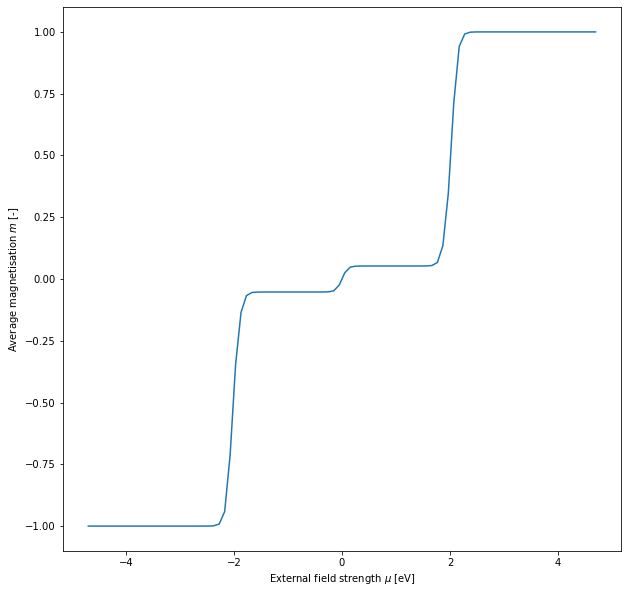

In [8]:
# Parameters
M = 19      # Size of the spin chain 
J = 1      # Exchange interaction
kT = 0.1   # Temperature

# Prepare plots
df = pd.DataFrame()

# Brute-Force (green)
for mu in np.linspace(-5,5,100):
    bf = transfer_matrix(M,J,mu,[kT])
    df = pd.concat([df,bf])

plt.figure(figsize=(10,10))
print(list(df))
plt.plot(df['mu'],df['m'])
plt.xlabel('External field strength $\mu$ [eV]')
plt.ylabel('Average magnetisation $m$ [-]')
plt.show()

### Analytical solution

The transfer matrix can be solved analytically. The eigenvalues of the transfer matrix

$$
{\bf T} = \left[
\begin{array}{cc}
\exp(J-\mu) & \exp(-J+\mu) \\
\exp(-J-\mu) & \exp(J+\mu) \\
\end{array}
\right]
$$

are

$$
\lambda_\pm = \exp(-\beta J)\cdot\cosh(\beta\cdot\mu) \pm \sqrt{
    \exp(-2\beta J)\cdot\sinh^2(\beta\cdot\mu) + \exp(2\beta/ J)
}
$$

Once the eigenvalues are known, the partition function becomes 

$$
Z = \lambda^N_+ + \lambda^N_- \quad {N\rightarrow\infty} \quad Z \approx \lambda^N_+
$$

In the thermodynamic limit ($N\rightarrow\infty$) the largest eigenvalue dominates and the thermodynamic properties can be computed from

$$
g = -kT\cdot\ln(\lambda_+)/N\quad
u = -\frac{\partial \ln(\lambda_+)}{\partial \beta}/N\quad
m = \frac{\partial g}{\partial \mu}
$$

In [9]:
def analytical_solution(J,mu,kTs):
    '''
    Solve the one-dimensional Ising model analytically through the 
    transfer matrix formalism.
    
    The function returns the results as a Pandas dataframe containing the free energy g,
    the internal energy u, and the magnetisation m
    
    Parameters:
        
        J   - exchange interaction
        mu  - external field (same units as J)
        kTs - array with temperatures (in units of J)
    
    Returns:
    
        A Pandas dataframe with free energy g, internal energy u, magnetisation m
        
    Usage: 
        
        analytical_solution(-1,0.1,np.linspace(0.1,4,30))
    '''
    
    betas = 1/kTs

    # Create a new data-frame to take results
    df = pd.DataFrame(columns=['kT','g','u','m'],dtype=object)
    
    ## Eigenvalue
    lmbda = np.exp(-betas*J)*np.cosh(betas*mu) \
          + np.sqrt(np.exp(-2*betas*J)*np.sinh(betas*mu)**2 + np.exp(2*betas*J))
    
    # Free Energy
    g = -1/betas*np.log(lmbda)

    # Internal energy (fairly long expression)
    ua = np.exp(J*betas)*np.cosh(betas*mu)
    ub = np.exp(J*betas)*mu*np.sinh(betas*mu)
    uc = mu*np.cosh(betas*mu)*np.sinh(betas*mu) + J*(np.exp(4*J*betas)-np.sinh(betas*mu)**2)
    ud = np.sqrt(np.exp(-2*betas*J)*(np.exp(4*J*betas)+np.sinh(betas*mu)**2))
    ue = np.exp(-J*betas)*np.cosh(betas*mu)
    u = -np.exp(-2*J*betas)*(-J*ua+ub+uc/ud)/(ue+ud)

    # Magnetisation
    m = np.exp(-betas*J)*np.sinh(betas*mu)/np.sqrt(np.exp(-2*betas*J)*np.sinh(betas*mu)**2 + np.exp(2*betas*J))

    df['u'] = u
    df['g'] = g
    df['m'] = m
    df['kT'] = kTs
    # df['mu'] = np.ones(len(mus))*mus
    return df




## Excercise 3: Scaling analysis

Let's first check that all three methods yield similar results and then see how the "Brute Force" method scales with chain length compared to the "Transfer Matrix" method.

Brute force solution took 0.49805712699890137 sec
Avg. error Brute Force free energy       : 0.0006439824293777207
Avg. error Brute Force magnetisation     : 0.01060166266750696
Transfer matrix solution took 0.02721095085144043 sec
Avg. error Transfer Matrix free energy   : 0.0006439824293775987
Avg. error Transfer Matrix magnetisation : 0.010601662667506898


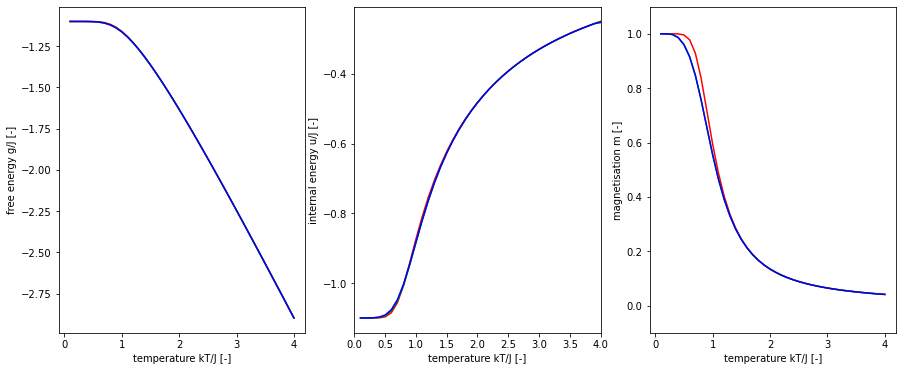

In [12]:
# Parameters
kTs =np.linspace(0.1,4,40)
M = 10
J = -1
mu = 0.1

# Prepare plots
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# Analytical solution (red)
an = analytical_solution(J,mu,kTs)
ax1.plot(np.abs(an.kT/J),an.g/np.abs(J),'r')
ax2.plot(np.abs(an.kT/J),an.u/np.abs(J),'r')
ax3.plot(np.abs(an.kT/J),an.m,'r')

# Brute-Force (green)
start = time.time()
bf = brute_force(M,J,mu,kTs)
end = time.time()    
print("Brute force solution took {} sec".format(end-start))
ax1.plot(np.abs(bf.kT/J),bf.g/np.abs(J),'g-')
ax2.plot(np.abs(bf.kT/J),bf.u/np.abs(J),'g-')
ax3.plot(np.abs(bf.kT/J),bf.m,'g-')
bfg_arr = bf.g.to_numpy()
ang_arr = an.g.to_numpy()

bfm_arr = bf.m.to_numpy()
anm_arr = an.m.to_numpy()

print("Avg. error Brute Force free energy       : {}".format(np.average(np.abs(bfg_arr - ang_arr))))
print("Avg. error Brute Force magnetisation     : {}".format(np.average(np.abs(bfm_arr - anm_arr))))

    
# Transfer Matrix (blue)
start = time.time()
tm = transfer_matrix(M,J,mu,kTs)
tmg_arr = tm.g.to_numpy()
tmm_arr = tm.m.to_numpy()
end = time.time()    
print("Transfer matrix solution took {} sec".format(end-start))
ax1.plot(np.abs(tm.kT/J),tm.g/np.abs(J),'b-')
ax2.plot(np.abs(tm.kT/J),tm.u/np.abs(J),'b-')
ax3.plot(np.abs(tm.kT/J),tm.m,'b-')
print("Avg. error Transfer Matrix free energy   : {}".format(np.average(np.abs(tmg_arr-ang_arr))))
print("Avg. error Transfer Matrix magnetisation : {}".format(np.average(np.abs(tmm_arr-anm_arr))))

ax1.set_xlabel('temperature kT/J [-]')
ax1.set_ylabel('free energy g/J [-]')
ax2.set_xlabel('temperature kT/J [-]')
ax2.set_ylabel('internal energy u/J [-]')
ax3.set_xlabel('temperature kT/J [-]')
ax3.set_ylabel('magnetisation m [-]')

ax2.set_xlim([0,4])
ax3.set_ylim([-0.1,1.1])
fig.show()